In [2]:
import time
import copy
import matplotlib.pyplot as plt

import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from finetune.cifar10_models import resnet18

# Pre-trained models for dissimilar data

Previously, we have seen the power of pre-trained models in classification of images. In this problem, we show the utility of pre-trained models when performing tasks that are dissimilar to the one they were trained for.

Run the code below to download and visualize the data. It may take a couple minutes to download the data.

In [3]:
class_label_to_name = {0: "T-shirt/top",
                        1: "Trouser",
                        2: "Pullover",
                        3: "Dress",
                        4: "Coat",
                        5: "Sandal",
                        6: "Shirt",
                        7: "Sneaker",
                        8: "Bag",
                        9: "Ankle boot"}

# transforms to match mean and std of original dataset
trfms = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize([0.4914], [0.2470])])

# download the data
dataset = torchvision.datasets.FashionMNIST('data', transform=trfms, download=True)
val_dataset = torchvision.datasets.FashionMNIST('data', transform=trfms, train=False, download=True)

cifar10 = torchvision.datasets.CIFAR10('data', download=True)

Files already downloaded and verified


## Part a

For this question, we will be working with ResNet-18 pre-trained on ImageNet. Our task will be to classify types of clothing from a dataset called Fashion-MNIST.

First, let's visualize the data from both datasets. Run the following cells and then answer the questions below.

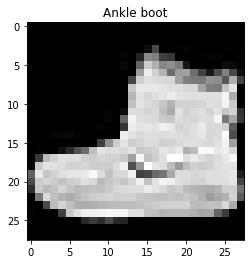

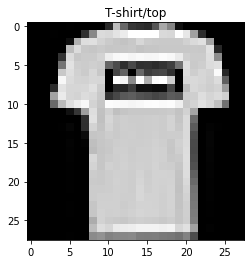

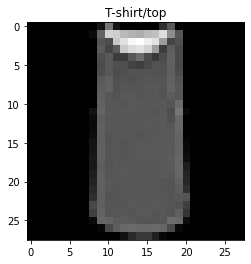

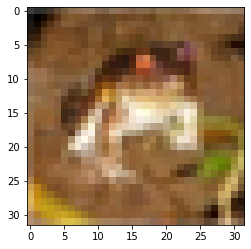

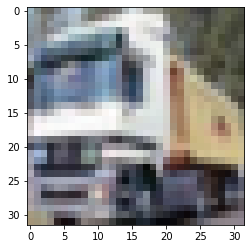

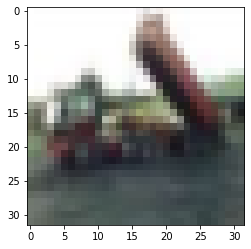

In [4]:
for i, data in enumerate(dataset):
    if i > 2:
        break
    img, label = data
    img = img.numpy().squeeze()
    plt.imshow(img, cmap='gray')
    plt.title(class_label_to_name[label])
    plt.show()
    
for i, data in enumerate(cifar10):
    if i > 2: 
        break
    img, label = data
    plt.imshow(img)
    plt.show()

## What do you observe about the data?



## Looking at the data, how do you think each of these models will perform and why?

1. A basic CNN

2. A pre-trained model with no extra training

3. A pre-trained model with all but the last layer frozen

4. A basic CNN using a pre-trained model for feature extraction



# Part b
Now we will implement a basic CNN in order to benchmark performance on this task. Fill in the get_width function the same as you did in question 2. You may use your code from previous parts or choose a new architecture for this problem.

We recommend trying this problem with as little reference to problem 2 as possible. While the goal of this notebook is not to explicitly teach you how to create a CNN, this is a beneficial skill to have and to practice.

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, num_classes, input_width, input_height, num_channels, num_layers=2, num_filters=[10, 20], kernel_sizes=[5, 5], pool=[True, True]):
        super(ConvNet, self).__init__()
        ### TODO create CNN
        
        
        ### End TODO

    def forward(self, x):
        ### TODO complete forward pass function
        
        
        
        ### End TODO
        return x # this should be the result after x is passed through the network
    
    # assume max pool with filter width 2 and stride 2
    def get_width(self, input_width, kernel_size, pool):
        ### Optional TODO complete this function (you may or may not need it)
        
        ### End TODO
        return conv_width

Now we will create our simple CNN just like we did in problem 2. Determine the size of our input and output (how did you do this in problem 2?) and print out the model architecture and verify this is what you expect.

In [ ]:
# TODO create the ConvNet with the correct input and output size


# End TODO
cnn = ConvNet(num_classes, input_width, input_height, num_channels)
print(cnn)

Now we will define a training loop and train our CNN on this dataset. Again for this part, we reccomend creating this function without referencing problem 2 as this is a vital skill.

In [ ]:
def train_model(model, dataloaders, criterion, feature_extract=True, num_epochs=25):
    """Train a model and save best weights
    
    Adapted From:
        https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
    
    Args:
        model (nn.Module): Model to train
        dataloaders ([dataloader, dataloader]): Training dataloader and validation dataloader
        criterion (function): Loss function
        optimizer (torch.optim): Optimizer for training
        num_epochs (int, optional): Number of epochs to train for. Defaults to 25.
    Returns:
        (model, validation_accuracy): Model with best weights, Array of validation loss over training
    """
    since = time.time()
    
    params_to_update = model.parameters()
    
    # this creates a list of all trainable parameters in the model
    # for a basic CNN, this is not needed, but we may freeze some weights
    # when transfer learning which makes this snippet of code important
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                print("\t",name)

    # optimizer only updates parameters that are un-frozen
    optimizer = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)
        
    # Useful if your environment supports CUDA; don't worry about it if it doesn't
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    val_acc_history = []
    ### TODO create training loop
    
    ### -- Loop through training data num_epochs times
    ### ---- DONT FORGET to call `inputs, labels = inputs.to(device), labels.to(device)`
    ### ---- so that your inputs and labels will be put on the GPU if you are using one
    
    ### -- Get model predictions, compute loss, call optimizer
    ### -- Get model predictions on validation data, compute accuracy, add to `val_acc_history`
    
    ### End TODO
    return model, val_acc_history

def visualize_model(model, dataloaders, num_images=6):
    # Utility function for visualizing predictions
    # @source https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # plotting images for train/val history
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_label_to_name[preds[j].item()]))
                plt.imshow(inputs.data[j].numpy().transpose(1, 2, 0).squeeze().clip(0, 1), cmap='gray')

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Run the cell below in order to train your cnn. This should take about ~5 minutes for 10 epochs if you're using the default architecture. Does the performance match what you were expecting?

In [ ]:
# train the model
batch_size = 32
train_data_loader = torch.utils.data.DataLoader(dataset,
                                    batch_size=batch_size,
                                    shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_dataset,
                                    batch_size=batch_size,
                                    shuffle=True)

dataloaders = {'train':train_data_loader, "val": val_data_loader}

criterion = nn.CrossEntropyLoss()
trained_model, val_acc = train_model(cnn, dataloaders, criterion, feature_extract=False, num_epochs=10)

In [ ]:
# Visualize validation loss and some predictions
plt.plot(range(len(val_acc)), val_acc)
plt.title("Val Accuracy for basic CNN")
plt.show()

visualize_model(trained_model, dataloaders, num_images=6)

## Your observations here
How does the basic CNN perform? Was this what you expected?


# Part c
Now we will use a pre-trained model with no fine-tuning. Because we will not be fine-tuning the model, we are not going to change the input or output size. This is possible because we are using a resnet18 that is pre-trained on CIFAR-10, which happens to have the same number of classes as our new dataset. 

Complete the code below to examine the architecture of our pre-trained model. What do you notice?

In [ ]:
resnet = resnet18(pretrained=True)
# TODO print out resnet-18

# end of TODO

## Your observations here
How does this model compare to our previous one? Do you see any problems with the existing architecture?


Run the cells below to see the accuracy of the pre-trained model on our data. This will take around 5 minutes. Make sure to read through the code to understand what is going on.

In [ ]:
def prediction_accuracy(model, dataloaders):
    """Computes accuracy on train and validation set"""
    since = time.time()
    
    model.eval()   # Set model to evaluate mode
    
    loss = {}
    acc = {}
    
    with torch.no_grad():
        for phase in ['train', 'val']:
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                
                # statistics
                running_corrects += torch.sum(preds == labels.data)

            acc[phase] = running_corrects.double() / len(dataloaders[phase].dataset)


    time_elapsed = time.time() - since
    print('Inference complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Training Accuracy: ", acc['train'], "Validation Accuracy: ", acc['val'])
    
    return acc

In [ ]:
batch_size = 64

# as you may have noticed in the previous part, the pre-trained resnet takes in 3 
# channel images and our data has only one channel, to circumvent this, we stack
# the single channel 3 times before passing it through our model
trfms = transforms.Compose([transforms.ToTensor(),
                            transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                            transforms.Normalize([0.4914, 0.4822, 0.4466], [0.2470, 0.2435, 0.2616]),
                            ])

# create datasets with transformations
dataset = torchvision.datasets.FashionMNIST('data', transform=trfms, download=True)
val_dataset = torchvision.datasets.FashionMNIST('data', transform=trfms, train=False, download=True)

# create dataloaders for training loop
train_data_loader = torch.utils.data.DataLoader(dataset,
                                    batch_size=batch_size,
                                    shuffle=True)

val_data_loader = torch.utils.data.DataLoader(val_dataset,
                                    batch_size=batch_size,
                                    shuffle=True)
dataloaders = {'train':train_data_loader, "val": val_data_loader}

acc = prediction_accuracy(resnet, dataloaders)
visualize_model(resnet, dataloaders, num_images=6)

## Your observations here
How does this performance compare to your basic CNN? Why is this the case? Is this what you expected?



# Part d
Now we will fine-tune our model on our new task by unfreezing just the last layer of our model. This part may look similar to the previous question, but is one of the most important concepts when using pre-trained models so it is good to get some practice with this.

First, let's freeze all of the layers except the last layer.

In [2]:
finetuned_resnet = resnet18(pretrained=True)

# TODO freeze all layers

# End TODO

# TODO re-initilize the last layer

# End TODO

print(finetuned_resnet)

Now let's train our model on our new task. Run the cells below. This will take around an hour to run 10 epochs. You may use 5 epochs but you may not get as good results.

In [ ]:
# train the model
finetuned_resnet, val_acc_resnet = train_model(finetuned_resnet, dataloaders, criterion, num_epochs=10)

In [ ]:
# Visualize validation loss and some predictions
plt.plot(range(len(val_acc_resnet)), val_acc_resnet)
plt.title("Val Accuracy for Fine-tuned Resnet-18")
plt.show()

visualize_model(finetuned_resnet, dataloaders, num_images=6)

## Your observations here
How does this performance compare to your basic CNN and the pre-trained model without fine-tuning? Why is this the case? Is this what you expected? 


# Part e
Now we will try a combination of the previous approaches by using a pre-trained model as a feature extractor and train a basic CNN using these features. This is similar in spirit to fine-tuning more (or all) layers of our pre-trained model, however this would take quite a long time and thus we opt for a quicker approach for demonstration purposes. 

The idea here is that the features from lower levels of our pre-trained network are more generalizable and can transfer across different tasks better.

In [ ]:
class FeaturizedConvNet(ConvNet):
    def __init__(self, num_classes, input_width, input_height, num_channels, num_layers=2, num_filters=[10, 20], kernel_sizes=[5, 5], pool=[True, True]):
        # instantiate ConvNet with input sizes (64, 14, 14) since this is the shape
        # of the extracted features. the kernel sizes are smaller because of the smaller shape
        super().__init__(num_classes, 14, 14, 64, kernel_sizes=[3, 3])
        
        resnet = resnet18(pretrained=True)
        # freeze all layers in resnet
        for params in resnet.parameters():
            params.requires_grad = False
        
        # use first 5 layers as feature extractor
        self.features = nn.Sequential(
            *list(resnet.children())[:-5]
        )

    def forward(self, x):
        # obtain features from resnet before passing through convnet
        x = self.features(x)
        return super().forward(x)

feature_extracted_cnn = FeaturizedConvNet(10, 28, 28, 3)

Run the cell below to train a your model with feature extraction. This should take about 15 minutes for 10 epochs.

In [ ]:
# train the model
trained_feature_cnn, val_acc_feature_cnn = train_model(feature_extracted_cnn, dataloaders, criterion, num_epochs=10)

In [ ]:
# Visualize validation loss and some predictions
plt.plot(range(len(val_acc_feature_cnn)), val_acc_feature_cnn)
plt.title("Val Accuracy for CNN with ResNet features")
plt.show()

visualize_model(trained_feature_cnn, dataloaders, num_images=6)

## Your observations here
How does this performance compare to the previous models? Why is this the case? Is this what you expected?


## Final Takeaways
What are the main takeaways from this notebook? Which method achieved the highest accuracy? Why was this/How did the dataset and task impact performance? Compare and contrast this to what you have learned in problems 1 and 2. 

